# Modelos QSAR-GTM para protease principal 3C-like protease (M<sup>pro</sup>) de SARS-CoV

Os modelos nesse fluxo de trabalho foram criados usando as impressões digitais de Morgan com Random Forest scikit-learn.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import _pickle as cPickle
import gzip
import ugtm
import altair as alt

#BalanceBySim: função de balanceamento de conjunto de dados (Equilibre os dados usando 1/2 similaridade e 1/2 aleatória)
from BalanceBySim import *

#Stats: Calculos estatisticos referente ao modelo Kappa	CCR	Sensitivity	PPV	Specificity	NPV	Coverage
from stats import *

from collections import Counter

#Rdkit: coleção de quiminformática e software de aprendizado de máquina escrito em C++ e Python de Código Aberto.
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

#Sklearn: Bibliotecas p/ Machine learning de Código Aberto
from sklearn import metrics, preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import permutation_test_score, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn import manifold

# Bibliotecas do GTM
from ugtm import eGTM, eGTC, eGTR, crossvalidateGTC

def warn(*args, **kwargs):
    pass
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%reload_ext autoreload
%autoreload 2
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Dados originais:  (113, 11)
Dados mantidos:  (113, 11)


,Compound_name,Standard Type,Standard Relation,Standard Value,Standard Units,Outcome,InChIKey,Molecule ChEMBL ID,ID,SMILES,Mol
0,,IC50,=,5700.0,nM,Active,AEYIBAPLFDNVGD-UHFFFAOYNA-N,,,CC(=O)NC(CO)C(=O)NC(C)C(=O)NC(C(=O)NC(CC(C)C)C...,

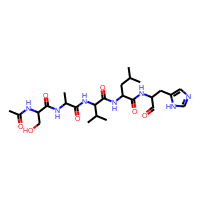

In [2]:
# Definir caminho do arquivo
file = 'datasets/curated_data/chembl-pdb-sars-cov-3C-like-proteinase.sdf.gz'

# Novo dicionário inicializado a partir de um objeto de mapeamento
sdfInfo = dict(smilesName='SMILES', molColName='ROMol')

# Carregando o arquivo SDF com os dicionarios mapeados
moldf = PandasTools.LoadSDF(file, **sdfInfo)
print('Dados originais: ', moldf.shape)

# Renomear ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})

# Remover moléculas RDKit ausentes
moldf = moldf[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf = moldf.drop(columns='StandardizerResult')
    
# Colunas
print('Dados mantidos: ', moldf.shape)
moldf.head(1)

In [3]:
# (27 ativos e 64 inativos) 91 compostos utilizando o software ChemAxon Standardizer 
# (13 ativos e 09 inativos) 22 compostos obtidos de empresas encontradas do PDB

moldf['Outcome'] = moldf['Outcome'].replace('Active', 1)
moldf['Outcome'] = moldf['Outcome'].replace('Inactive', 0)

classes = Counter(moldf['Outcome'])
print('\033[1m' + 'Forma do conjunto de treinamento:' + '\n' + '\033[0m')
for key, value in classes.items():
    print('\t\t Class %d: %d' % (key, value))
print('\t\t Número total de compostos: %d' % (len(moldf['Outcome'])))

Forma do conjunto de treinamento:

		 Class 1: 40
		 Class 0: 73
		 Número total de compostos: 113


In [4]:
# Calculando os descritores fingerprints de Harry Morgan (vetores de bits).
def calcfp(mol,funcFPInfo=dict(radius=3, nBits=2048, useFeatures=False, useChirality=False)):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

# Conjunto de treinamento
desc = moldf.Mol.apply(calcfp)
descriptors = desc.columns.difference(moldf.columns).tolist()
desc.shape

(113, 2048)

In [5]:
moldf_desc = pd.concat([moldf,desc], axis=1)
balance_data = 'no'

if balance_data == 'yes':
    # Equilibre os dados usando 1/2 similaridade e 1/2 aleatória
    moldf_desc = BalanceBySim(moldf_desc, 'Outcome', 2)
    # Forma de impressão
    print('Forma do conjunto de treinamento: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'train']))
    print('Forma externa definida: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))
      
else:
    moldf_desc['Set'] = 'train'
    # Forma de impressão
    print('Forma do conjunto de treinamento: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'train']))
    print('Forma externa definida: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))

Forma do conjunto de treinamento: Counter({0: 73, 1: 40})
Forma externa definida: Counter()


In [6]:
moldf_train = moldf_desc[(moldf_desc['Set'] == 'train')]

y = moldf_train['Outcome'].to_numpy()
X = moldf_train[descriptors]
X.shape

(113, 2048)

In [9]:
#Classificador GTM (GTC), bayesiano
tuned_params = {'regul': [100, 250, 500, 750, 1000],
                's': [0.1, 0.2, 0.3],
                'k': [16],
                'm': [4]}

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=24)

#Construção do modelo de configuração
grid_search = GridSearchCV(eGTC(), tuned_params, cv=3, refit = True, iid=False, scoring='balanced_accuracy')

# Prever rótulos para X_test
grid_search_gtc = grid_search.fit(X_train, y_train)
print()

#Retorna a melhor pontuação e os melhores parâmetros
print('Melhores parametros: %s' % grid_search_gtc.best_params_)
print('Score: %.2f' % grid_search_gtc.best_score_)


Melhores parametros: {'k': 16, 'm': 4, 'regul': 250, 's': 0.3}
Score: 0.74


##### Modelo com w/ melhores parâmetros

In [40]:
gtm_best = eGTC(k=16, m=4, regul=250, s=0.3)
gtm_best.fit(X_train, y_train)
y_true, y_pred = y_test, gtm_best.predict(X_test)
# Testar dados usando o modelo construído com os melhores parâmetros
print(classification_report(y_true, y_pred))

eGTC(k=16, m=4, niter=200, prior='estimated', random_state=1234, regul=250,
     s=0.3, verbose=False)

              precision    recall  f1-score   support

           0       0.75      0.89      0.81        37
           1       0.69      0.45      0.55        20

    accuracy                           0.74        57
   macro avg       0.72      0.67      0.68        57
weighted avg       0.73      0.74      0.72        57



##### Modelo com w/ melhores parâmetros

##### Mapa das classes

In [11]:
# optional preprocessing
dfclassmap = pd.DataFrame(gtm_best.optimizedModel.matX, columns=["x1", "x2"])
dfclassmap["rótulo_do_nó_previsto"] = gtm_best.node_label
dfclassmap["probabilidade_de_classe_predominante"] = np.max(gtm_best.node_probabilities,axis=1)

# Classification map
alt.Chart(dfclassmap).mark_square().encode(
    x='x1',
    y='x2',
    color='rótulo_do_nó_previsto:N',
    size=alt.value(50),
    opacity='probabilidade_de_classe_predominante:Q',
    tooltip=['x1','x2', 'rótulo_do_nó_previsto:N', 'probabilidade_de_classe_predominante:Q']
).properties(title = "Mapa das Classes", width = 200, height = 200)

alt.Chart(...)

##### Plot maps hand-written digits

In [17]:
man = manifold.TSNE(n_components=2, init='pca', random_state=0)
tsne = man.fit_transform(X_train)
man = manifold.MDS(max_iter=100, n_init=1, random_state=0)
mds = man.fit_transform(X_train)
man = manifold.LocallyLinearEmbedding(n_neighbors=20, n_components=2,
                                      eigen_solver='auto',
                                      method="standard",
                                      random_state=0)
lle = man.fit_transform(X_train)

# Construct GTM
gtm = eGTM().fit(X_train)
gtm_means = gtm.transform(X_train,model="means")
gtm_modes = gtm.transform(X_train,model="modes")

dgtm_modes = pd.DataFrame(gtm_modes, columns=["x1", "x2"])
dgtm_modes["label"] = y_train

gtm_modes = alt.Chart(dgtm_modes).mark_circle().encode(
    x='x1',
    y='x2',
    color=alt.Color('label:N',
                    scale=alt.Scale(scheme='viridis')),
    size=alt.value(50),
    tooltip=['x1','x2','label:N']
).properties(title = "GTM (modes)", width = 100, height = 100)

dgtm_means = pd.DataFrame(gtm_means, columns=["x1", "x2"])
dgtm_means["label"] = y_train

gtm_means = alt.Chart(dgtm_means).mark_circle().encode(
    x='x1',
    y='x2',
    color=alt.Color('label:N',
                    scale=alt.Scale(scheme='viridis')),
    size=alt.value(50),
    tooltip=['x1','x2','label:N']
).properties(title = "GTM (means)", width = 100, height = 100)

#Construct activity landscape
dfclassmap = pd.DataFrame(gtm_best.optimizedModel.matX, columns=["x1", "x2"])
dfclassmap["label"] = gtm_best.node_label

# Classification map
gtc = alt.Chart(dfclassmap).mark_square().encode(
    x='x1',
    y='x2',
    color=alt.Color('label:N',
                    scale=alt.Scale(scheme='viridis')),
    size=alt.value(50),
    tooltip=['x1','x2', 'label:N'],
    #opacity='density'
).properties(title = "GTM class map",width = 100, height = 100)

dtsne = pd.DataFrame(tsne, columns=["x1", "x2"])
dmds = pd.DataFrame(mds, columns=["x1", "x2"])
dlle = pd.DataFrame(lle, columns=["x1", "x2"])
dtsne["label"] = y_train
dmds["label"] = y_train
dlle["label"] = y_train

tsne = alt.Chart(dtsne).mark_circle().encode(
    x='x1',
    y='x2',
    color=alt.Color('label:N',
                    scale=alt.Scale(scheme='viridis')),
    size=alt.value(50),
    tooltip=['x1','x2','label:N']
).properties(title = "t-SNE", width = 100, height = 100)

mds = alt.Chart(dmds).mark_circle().encode(
    x='x1',
    y='x2',
    color=alt.Color('label:N',
                    scale=alt.Scale(scheme='viridis')),
    size=alt.value(50),
    tooltip=['x1','x2','label:N']
).properties(title = "MDS", width = 100, height = 100)

lle = alt.Chart(dlle).mark_circle().encode(
    x='x1',
    y='x2',
    color=alt.Color('label:N',
                    scale=alt.Scale(scheme='viridis')),
    size=alt.value(50),
    tooltip=['x1','x2','label:N']
).properties(title = "LLE", width = 100, height = 100)


gtm = gtm_means | gtm_modes | gtc
others = tsne | mds | lle

alt.vconcat(gtm, others)

alt.VConcatChart(...)

##### Validação cruzada 5 vezes

In [41]:
ugtm.crossvalidateSVC(data=X_train,labels=y_train,C=1)

Classes:  [0 1]
nClasses:  2

model	parameters=C	recall with CI	precision with CI	F1-score with CI



KeyError: "None of [Int64Index([ 0,  1,  3,  5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 17, 18, 19, 20,\n            21, 22, 23, 24, 25, 27, 28, 29, 31, 34, 35, 36, 37, 38, 39, 41, 42,\n            44, 47, 48, 49, 50, 51, 52, 53, 54, 55],\n           dtype='int64')] are in the [columns]"